# DFT experiment
### In the following experiment, we implement the Discrete Fourier Transformation in four different ways, the naive way, the divide and conquer way, using numpy's FFT, and using sparse matrix multiplication, and evaluate the executing time.

## Step 0: import all necessary toolkits.

In [1]:
import numpy as np
import scipy as scp
import time
import math
import matplotlib.pyplot as plt
from math import cos as cos
from math import sin as sin
from math import pi as pi
from math import log2 as log2
from math import log10 as lg
from math import exp
from scipy.sparse import block_diag
from scipy import sparse

## Step 1: Generating sequences
### from 2 to $2^{24}$ ,and check one of the seuqence.

In [2]:
# 1.Generating integer sequences;
sequences=[]
for i in range(1,24):
    sample=[]
    for j in range(2**(i)):
        sample.append(np.random.randint(0,10))
    sequences.append(sample)

In [3]:
print(sequences[4]) #This is 2**5.

[9, 4, 6, 6, 6, 7, 6, 1, 0, 0, 8, 6, 2, 1, 8, 5, 0, 3, 1, 3, 5, 0, 5, 7, 6, 9, 0, 0, 0, 7, 7, 3]


## Step 2: Using for iteration to compute DFT (Naive way)
### This needs $O(n^2)$.

### Naive DFT:
The naive dft can be expressed as: $\displaystyle X[k]=\sum_{n=0}^{N-1}x[n]W_N^{k}$, with $\displaystyle W_N^k=e^{-j\dfrac{2\pi}{N}nk}$, with $j$ is the unit imaginary.

For each k, it will operate multiplication and add for $2n-1$ times and $n$ times to calculate all $X[k]$. So the asymptotic time complexity is $O(n^2)$.

For a better result output, we round the bits to 8 digit.

In [4]:
def DFT_0(sample):
    sample_output=[]
    N=len(sample)
    for i in range(N):
        real=0
        img=0
        for j in range(N):
            real+=sample[j]*cos(-2*pi*i*j/N)
            img+=sample[j]*sin(-2*pi*i*j/N)    # in fact this should be count in complexity.
        # After inner iteration
        real=round(real,8)
        img=round(img,8)
        output=complex(real,img)
        end_time=time.time()
        sample_output.append(output)
    return sample_output

In [5]:
test_sample=[0,1,2,3,4,5,6,7]
output=DFT_0(test_sample)
for i in range(len(test_sample)):
    print(output[i],end=',')
    if i%3==2:
        print('\n')
np.fft.fft(test_sample)

(28+0j),(-4+9.65685425j),(-4+4j),

(-4+1.65685425j),(-4-0j),(-4-1.65685425j),

(-4-4j),(-4-9.65685425j),

array([28.+0.j        , -4.+9.65685425j, -4.+4.j        , -4.+1.65685425j,
       -4.+0.j        , -4.-1.65685425j, -4.-4.j        , -4.-9.65685425j])

## Step 2: Use Divide and conquer to do DFT.
Note that the recurse of python is time comsuming, we developed a new method that compute DFT in iteration.
### Step 2.1 Bit reverse and data pre_load.

### The following method is called the gold raden algorithm. The time complexity for getiing the bit reversed is $O(n\log{n})$.
From: An_improved_FFT_digit-reversal_algorithm,1989

<img src="./1.png" align="center" width="370" height="400">


### But we implemented a faster liniear bit reverse algorithm of $O(n)$.

We started from 0. we can easy find that $bitRev(0)=0$. When implementing $bitRev(x)$, $bitRev(\lfloor \dfrac{x}{2}\rfloor)$ is known. So we can rigfht shift x, then flip, then rigt shift one bit, we can have the bit reverse result except LSB.

Consider LSB now. If LSB is 0, then MSB after flip is 0. Else,MSB is 1. So we should add $2^{N-1}$ for a N digit bit reverse.

For example, set N=5.

1. For $(1100)_2$, the left shift of it stores $(00110)_2$. Right shift this again get $(00011)_2$.

2. For LSB, it is 1, so we should add $2^4$. Here we can implement by bitOR.

3. Identify LSB is 1 or 0, we can use bitAND with 1 to judge it. So $(i\&1)<<(l-1)$ is: when LSB is 1, we add $2^{N-1}$. Else keep it.

### The algorithm is developed by Elster, 1989.

From: Fast Bit-Reversal algorithms.

<img src='./2.png'>

In [6]:
def bitrev(inv):
    l=1
    n=len(inv)
    while (1 << l) < n: l+=1
    for i in range(len(inv)):
        inv[i]=(inv[i>>1]>>1) | (i&1)<<(l-1) # This is a magic function!!!

def gen_inv(N):
    inv=[]
    for i in range(N):
        inv.append(i)
    return inv

def data_deal(sample):
    N=len(sample)
    sample_dealed=[]
    inv=gen_inv(N)
    bitrev(inv)
    for i in range(N):
        sample_dealed.append(sample[inv[i]])
    return sample_dealed

In [7]:
inv=gen_inv(8)
bitrev(inv)
(inv)

[0, 4, 2, 6, 1, 5, 3, 7]

## Step 2: Implement the DFT by Divide and Conquer.
### By divide and conquer, we theoretically achieved $O(n\log{n})$. But in-built python may elapse more time.

In [8]:
def DFT_1_no_iter(sample):
    '''Use for 2**n sequences.'''
    sample=data_deal(sample)
    N=len(sample)
    output=list(sample)
    h=2
    while h<=N:
        j=0
        while j<N:
            for k in range(j,j+(h>>1)):
                w=complex(round(cos(-2*pi*(k-j)/h),8),round(sin(-2*pi*(k-j)/h),8))
                x=output[k]
                y=w*output[(h>>1)+k]
                output[k]=x+y
                output[(h>>1)+k]=x-y
            j+=h
        h <<= 1
    return output

The following is the verification of the correctness of our code.

In [9]:
print(np.fft.fft(sequences[4]))
output=DFT_1_no_iter(sequences[4])
for i in range(len(sequences[4])):
    print(output[i],end=',')
    if i%2==1:
        print('\n',end='')

[ 1.31000000e+02 +0.j          1.69529098e+01 -1.74822275j
  4.80429501e+00 -6.54685829j  1.24702187e+01-23.95301988j
  3.41421356e+00+11.j         -4.98392227e+00+25.19681831j
 -3.58220534e+00+15.14865984j -2.99495328e-02-30.07522858j
 -1.30000000e+01 +0.j          1.45822678e+01 -1.09583649j
  5.33956465e+00 -9.92240798j  8.40235492e+00+13.15243023j
  5.85786438e-01-11.j          2.29397757e+01 -3.51212658j
  5.43834568e+00 +4.38207389j  1.66634489e+00+11.71645071j
  7.00000000e+00 +0.j          1.66634489e+00-11.71645071j
  5.43834568e+00 -4.38207389j  2.29397757e+01 +3.51212658j
  5.85786438e-01+11.j          8.40235492e+00-13.15243023j
  5.33956465e+00 +9.92240798j  1.45822678e+01 +1.09583649j
 -1.30000000e+01 +0.j         -2.99495328e-02+30.07522858j
 -3.58220534e+00-15.14865984j -4.98392227e+00-25.19681831j
  3.41421356e+00-11.j          1.24702187e+01+23.95301988j
  4.80429501e+00 +6.54685829j  1.69529098e+01 +1.74822275j]
(131+0j),(16.952909752589143-1.748222705588959j),
(4.80

## Step 3: Using Matrix multiplication
### To calculate the DFT by matrix.
### Note that naive matrix multiplication is $O(n^3)$, and by sparse matrix multiplication, we use compress by row matrix to calculate it. Thus it is $O(an^2+bn^2)$ for a and b are compressed row numbers.

In [10]:
def Matrix_gen(N):
    count = 1
    j=complex(0,1)
    final_matrix=sparse.identity(N)
    N=N >> 1
    while N>0:
        identity=np.identity(N)
        omega=np.diag([w:=complex(round(cos(-2*pi*i/(N << 1)),8),round(sin(-2*pi*i/(N << 1)),8)) for i in range(N)])
        factor=np.concatenate((np.concatenate((identity,omega),axis=1),np.concatenate((identity,(-1)*omega),axis=1)),axis=0)
        B=factor
        for _ in range(count-1):
            B=block_diag((B,factor))
        B=sparse.csr_matrix(B)
        final_matrix=final_matrix.dot(B)
        N=N >> 1
        count=count << 1
    return final_matrix

def matrix_fft(sample):
    N=len(sample)
    sample_dealed=np.array(data_deal(sample)).reshape((len(sample),1))
    sample_dealed=sparse.csr_matrix(sample_dealed)
    matrix=Matrix_gen(N)
    output=matrix.dot(sample_dealed)
    return output

In [11]:
sample=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
print(np.fft.fft(sample))
print(matrix_fft(sample))

[120. +0.j          -8.+40.21871594j  -8.+19.3137085j   -8.+11.9728461j
  -8. +8.j          -8. +5.3454291j   -8. +3.3137085j   -8. +1.59129894j
  -8. +0.j          -8. -1.59129894j  -8. -3.3137085j   -8. -5.3454291j
  -8. -8.j          -8.-11.9728461j   -8.-19.3137085j   -8.-40.21871594j]
  (0, 0)	(120+0j)
  (1, 0)	(-8.000000032853514+40.21871583305942j)
  (2, 0)	(-8.000000000000002+19.313708480000003j)
  (3, 0)	(-8.000000006940585+11.972846047146486j)
  (4, 0)	(-8+8j)
  (5, 0)	(-7.999999993059415+5.345429087146488j)
  (6, 0)	(-8.000000000000002+3.3137084799999985j)
  (7, 0)	(-7.999999967146487+1.591298873059415j)
  (8, 0)	(-8+0j)
  (9, 0)	(-7.999999967146487-1.591298873059415j)
  (10, 0)	(-8.000000000000002-3.3137084799999985j)
  (11, 0)	(-7.999999993059415-5.345429087146488j)
  (12, 0)	(-8-8j)
  (13, 0)	(-8.000000006940585-11.972846047146486j)
  (14, 0)	(-8.000000000000002-19.313708480000003j)
  (15, 0)	(-8.000000032853514-40.21871583305942j)


## Step 4: Evaluate all times.
### Record their time.

In [12]:
times_DFT0=[]
times_DFT1=[]
times_FFT=[]
times_matrix=[]
for i in range(15):
    start_time=time.time()
    DFT_0(sequences[i])
    end_time=time.time()
    times_DFT0.append(end_time-start_time)
    

    start_time=time.time()
    matrix_fft(sequences[i])
    end_time=time.time()
    times_matrix.append(end_time-start_time)
    
for i in range(23):
    start_time=time.time()
    DFT_1_no_iter(sequences[i])
    end_time=time.time()
    times_DFT1.append(end_time-start_time)
    
    start_time=time.time()
    np.fft.fft(sequences[i])
    end_time=time.time()
    times_FFT.append(end_time-start_time)
    
print(times_matrix)
print(times_DFT0)
print(times_DFT1)
print(times_FFT)

[0.0006091594696044922, 0.0011360645294189453, 0.001583099365234375, 0.0011928081512451172, 0.0017788410186767578, 0.0031800270080566406, 0.006699085235595703, 0.016450166702270508, 0.04776787757873535, 0.15590596199035645, 0.5904786586761475, 2.448486804962158, 10.54252004623413, 46.66577982902527, 390.2903518676758]
[1.3113021850585938e-05, 1.4066696166992188e-05, 3.504753112792969e-05, 9.989738464355469e-05, 0.000347137451171875, 0.0013229846954345703, 0.00513005256652832, 0.020668983459472656, 0.12044787406921387, 0.3408517837524414, 1.3628661632537842, 5.508468866348267, 22.09361505508423, 88.01211380958557, 351.96764397621155]
[0.0013260841369628906, 1.2874603271484375e-05, 3.790855407714844e-05, 3.886222839355469e-05, 8.487701416015625e-05, 0.00048089027404785156, 0.0008027553558349609, 0.0010461807250976562, 0.0026628971099853516, 0.005625009536743164, 0.012336254119873047, 0.027042150497436523, 0.05887794494628906, 0.12899398803710938, 0.2731921672821045, 0.5682816505432129, 1

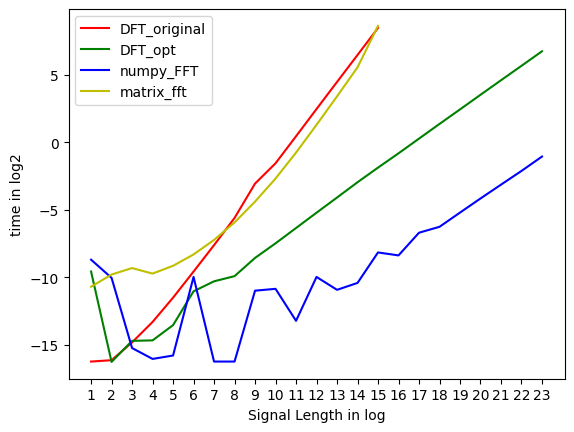

In [13]:
plt.plot([log2(times_DFT0[i]) for i in range(len(times_DFT0))],'r',label="DFT_original")
plt.plot([log2(times_DFT1[i]) for i in range(len(times_DFT1))],'g',label="DFT_opt")
plt.plot([log2(times_FFT[i]) for i in range(len(times_FFT))],'b',label="numpy_FFT")
plt.plot([log2(times_matrix[i]) for i in range(len(times_matrix))],'y',label="matrix_fft")
plt.xticks([i for i in range(len(sequences))],[i+1 for i in range(len(sequences))])
plt.xlabel("Signal Length in log")
plt.ylabel("time in log2")
plt.legend()
plt.show()